# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strengths
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **comp411/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file comp411/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from comp411.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.358128
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Softmax acts like it is providing a probability distribution and in the first place the weights are initilized to be to really low numbers so the probablities out from softmax should be nearly 1/10


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from comp411.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print("----------")
# similar to SVM case, do another gradient check with regularizations
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.191211 analytic: -0.191211, relative error: 7.818016e-08
numerical: -2.949981 analytic: -2.949981, relative error: 1.039541e-08
numerical: 1.954472 analytic: 1.954472, relative error: 5.708317e-08
numerical: 0.400711 analytic: 0.400711, relative error: 9.338466e-08
numerical: -2.348470 analytic: -2.348470, relative error: 3.786027e-09
numerical: 0.488238 analytic: 0.488238, relative error: 4.616335e-08
numerical: 0.634051 analytic: 0.634051, relative error: 1.861603e-07
numerical: -1.186644 analytic: -1.186644, relative error: 1.747813e-08
numerical: 2.071839 analytic: 2.071839, relative error: 8.503188e-09
numerical: 0.765605 analytic: 0.765605, relative error: 4.482971e-08
----------
numerical: 50.943734 analytic: 50.943734, relative error: 2.317103e-09
numerical: 50.481774 analytic: 50.481774, relative error: 1.007685e-10
numerical: 48.941302 analytic: 48.941302, relative error: 8.771473e-10
numerical: 48.069845 analytic: 48.069846, relative error: 4.340247e-10
numeric

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.358128e+00 computed in 0.134855s
vectorized loss: 2.358128e+00 computed in 0.003650s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from comp411.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be similar to the validation that you did for the SVM; save      #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths_l2 = [2.5e4, 5e4]
regularization_strengths_l1 = [0, 2.5e2, 5e2]


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
from comp411.classifiers import Softmax

for lr in learning_rates:
    for l2 in regularization_strengths_l2:
        for l1 in regularization_strengths_l1: 
            softMax = Softmax()
            softMax.train(X_dev, y_dev,learning_rate=lr, reg=l2, reg_l1 = l1,num_iters=100)
            yTrainPred = softMax.predict(X_train)
            train_accuracy = np.mean(yTrainPred == y_train)
            y_validation_pred =softMax.predict(X_val)
            val_accuracy = np.mean(y_validation_pred == y_val)
            results[(lr,l2,l1)] = (train_accuracy, val_accuracy)
            if best_val < val_accuracy:
                best_val = val_accuracy
                best_softmax = softMax

pass
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, rg_l2, rg_l1 in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rg_l2,rg_l1)]
    print('lr %e rg_l2 %e rg_l1 %e train accuracy: %f val accuracy: %f' % (
                lr, rg_l2, rg_l1, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 0.000000e+00 train accuracy: 0.152082 val accuracy: 0.172000
lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 2.500000e+02 train accuracy: 0.156163 val accuracy: 0.177000
lr 1.000000e-07 rg_l2 2.500000e+04 rg_l1 5.000000e+02 train accuracy: 0.177204 val accuracy: 0.179000
lr 1.000000e-07 rg_l2 5.000000e+04 rg_l1 0.000000e+00 train accuracy: 0.180122 val accuracy: 0.158000
lr 1.000000e-07 rg_l2 5.000000e+04 rg_l1 2.500000e+02 train accuracy: 0.175673 val accuracy: 0.176000
lr 1.000000e-07 rg_l2 5.000000e+04 rg_l1 5.000000e+02 train accuracy: 0.169633 val accuracy: 0.167000
lr 5.000000e-07 rg_l2 2.500000e+04 rg_l1 0.000000e+00 train accuracy: 0.285510 val accuracy: 0.287000
lr 5.000000e-07 rg_l2 2.500000e+04 rg_l1 2.500000e+02 train accuracy: 0.285347 val accuracy: 0.291000
lr 5.000000e-07 rg_l2 2.500000e+04 rg_l1 5.000000e+02 train accuracy: 0.282224 val accuracy: 0.296000
lr 5.000000e-07 rg_l2 5.000000e+04 rg_l1 0.000000e+00 train accuracy: 0.281918 val

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.312000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ The reson why a new added node doesnt change SVM loss is that the relative score difference of true class to other classes may be relatively high. In that case if true class score is high enough SVM loss may remain unchanged. However, in the case of Softmax it is not possible. Because Softmax cares about the probability distribution of the new node. Softmax wants the probability of new node's true class higher and Softmax always wants to enhance the probabilitistic distributions. That is to say, even if the new node is classified correctly with Softmax loss function, the loss of new node will never be 0.



**Inline Question 3** 

Comment on the effects of unifying L1 and L2 losses while using Elastic Net Regularization Loss? Did L2 loss achieve better when used alone or not?

$\color{blue}{\textit Your Comment:}$ In this case the L2 loss achived better alone. Statistically speaking, L1 loss is useful for feature selection as we can give 0 coefficient to some of the features. However L2 difference is more useful when it comes to distinguish or investigate collarated features. In this case L1 difference was useful when there is a problem to classify 10 classes and the pixels doesnt give you more information about the features of the image. Instead of using raw pixels, if we had used features of images L1 might worked well. 

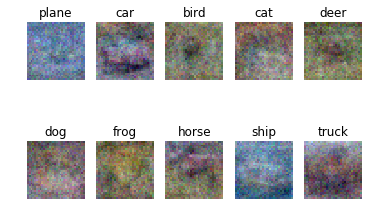

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])